# Object Detection using pretraind YOLO v5




- Fine-tune the largest YOLO v5 model
- Evaluate the model
- Look at some predictions



In [1]:
!nvidia-smi

Sun Dec 12 04:03:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!sudo apt-get install tree -qq > /dev/null

## Prerequisites
Installing some required libraries by the YOLOv5 project:

In [3]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.17
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4 MB 1.3 kB/s 
     |████████████████████████████████| 6.6 MB 44.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.1+cu101 which is incompatible.
     |████████████████████████████████| 20.3 MB 358 kB/s 
  Attempting uninstall

     |████████████████████████████████| 269 kB 5.3 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44635 sha256=88f2f5d12d5eb4066c53d30979888ecf6130c05472425c23589451251cafb6c0
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-98i8a2qd
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-98i8a2qd
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264953 sha256=f9a0b71cbaf3f9b6128942b32f686cf972437360da6becdfa88c17f255c9cc18
  Stored in directory: /tmp/pip-ephem-wheel-cache-n1oidenv/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built

We'll also install [Apex by NVIDIA](https://nvidia.github.io/apex/) to speed up the training of our model (this step is optional):

In [4]:
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Cloning into 'apex'...
remote: Enumerating objects: 8717, done.
remote: Counting objects: 100% (1085/1085), done.
remote: Compressing objects: 100% (246/246), done.
remote: Total 8717 (delta 963), reused 844 (delta 839), pack-reused 7632
Receiving objects: 100% (8717/8717), 14.38 MiB | 20.88 MiB/s, done.
Resolving deltas: 100% (5959/5959), done.
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
User install by explicit request
Created temporary directory: /tmp/pip-ephem-wheel-cache-poadtc80
Created temporary directory: /tmp/pip-req-tracker-tmog89c9
Initialized build tracking at /tmp/pip-req-tracker-tmog89c9
Created build tracker: /tmp/pip-req-tracker-tmog89c9
Entered build tracker: /tmp/pip-req-tracker-tmog89c9
Created temp

In [3]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

Each line in the dataset file contains a JSON object. Let's create a list of all annotations:

In [6]:
pwd

'/content'

In [7]:
!mkdir Connector_data

In [8]:
cd Connectror_data

[Errno 2] No such file or directory: 'Connectror_data'
/content


### Convert to YOLO format

YOLO v5 requires the dataset to be in the *darknet format*. Here's an outline of what it looks like:

- One txt with labels file per image
- One row per object
- Each row contains: `class_index bbox_x_center bbox_y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1


In [9]:
cd /content/Connector_data

/content/Connector_data


In [ ]:
!tree Connector_data -L 2

In [13]:
!cat /content/Connector_data/labels/train/IMG10.txt

0 0.457785 0.500000 0.519737 0.282500


## Fine-tuning YOLO v5

  YOLO models are one stage object detectors. 


cloning the GitHub repo and checking out a specific commit (to ensure reproducibility):

In [14]:
pwd/

'/content/Connector_data'

In [19]:
mkdir new

In [5]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
HEAD is now at ec72eea Merge remote-tracking branch 'origin/master'


We need two configuration files. One for the dataset and one for the model we're going to use. Let's download them:

This file specifies the paths to the training and validation sets. It also gives the number of classes and their names 

### Training





To train a model on a custom dataset, we'll call the `train.py` script. We'll pass a couple of parameters:

- img 640 - resize the images to 640x640 pixels
- batch 4 - 4 images per batch
- epochs 5 - train for 5 epochs
- data ./data/connector.yaml - path to dataset config
- cfg ./models/yolov5x.yaml - model config
- weights yolov5x.pt - use pre-trained weights from the YOLOv5x model
- name yolov5x_connector - name of our model
- cache - cache dataset images for faster training


In [27]:
!python /content/yolov5/train.py --img 800 --batch 1 --epochs 5 \
  --data /content/Connector.yaml --cfg /content/yolov5x_new.yaml --weights /content/yolov5/weights/download_weights.sh \
  --name yolov5x_connector --cache

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=False, batch_size=1, bucket='', cache_images=True, cfg='/content/yolov5x_new.yaml', data='/content/Connector.yaml', device='', epochs=5, evolve=False, img_size=[800], multi_scale=False, name='yolov5x_connector', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='/content/yolov5/weights/download_weights.sh')
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/

              from  n    params  module                                  arguments           

The training took around 30 minutes on Tesla P100. The best model checkpoint is saved to `weights/best_yolov5x_clothing.pt`.

## Evaluation

The project includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

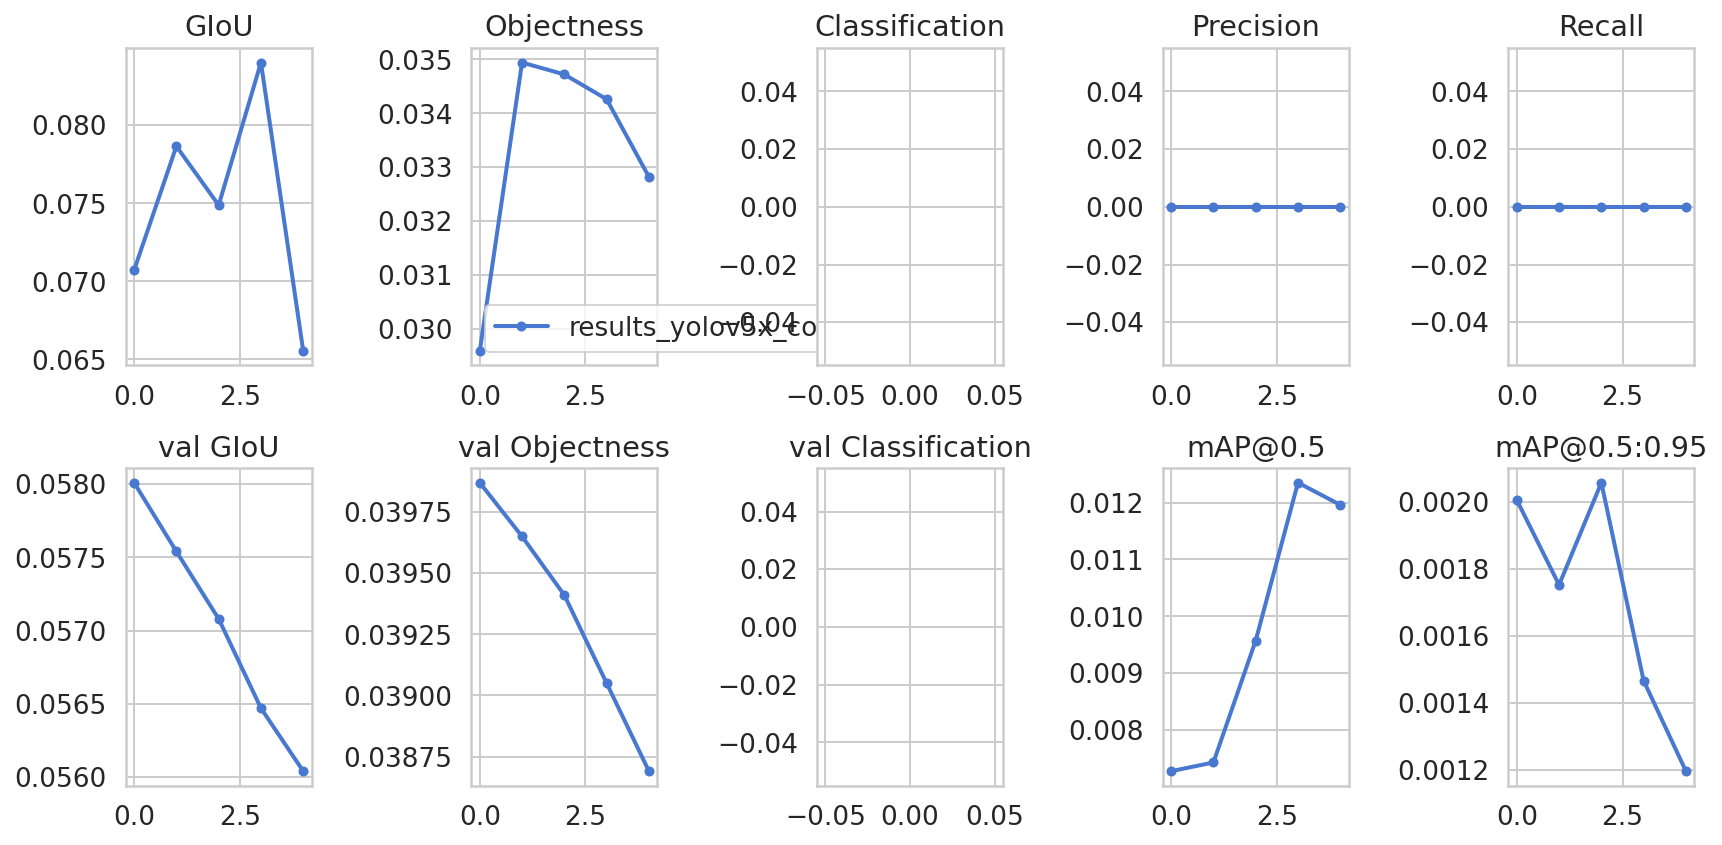

In [28]:
from utils.utils import plot_results

plot_results();

Looks like the mean average precision (mAP) is getting better throughout the training. The model might benefit from more training, but it is good enough.

## Making predictions

Let's pick 50 images from the validation set and move them to `inference/images` to see how our model does on those:

In [29]:
!find /content/Connector_data/images/train/ -maxdepth 1 -type f | head -2 | xargs cp -t "./inference/images/"

We'll use the `detect.py` script to run our model on the images. Here are the parameters we're using:

- weights weights/best_yolov5x_connector.pt - checkpoint of the model
- img 640 - resize the images to 640x640 px
- conf 0.4 - take into account predictions with confidence of 0.4 or higher
- source ./inference/images/ - path to the images

In [30]:
!python detect.py --weights /content/yolov5/weights/best_yolov5x_connector.pt \
  --img 800 --conf 0.4 --source ./inference/images/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', fourcc='mp4v', img_size=800, iou_thres=0.5, output='inference/output', save_txt=False, source='./inference/images/', view_img=False, weights='/content/yolov5/weights/best_yolov5x_connector.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

image 1/6 inference/images/IMG15.jpg: 800x416 Done. (0.196s)
image 2/6 inference/images/IMG16.jpg: 800x416 Done. (0.180s)
image 3/6 inference/images/IMG3.jpg: 800x608 Done. (0.223s)
image 4/6 inference/images/IMG7.jpg: 800x416 Done. (0.174s)
image 5/6 inference/images/bus.jpg: 800x608 Done. (0.220s)
image 6/6 inference/images/zidane.jpg: 480x800 Done. (0.190s)
Results saved to /content/yolov5/inference/output
Done. (3.021s)


We'll write a helper function to show the results:

In [34]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.view(1, -1)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [32]:
img_paths = list(Path("inference/output").glob("*.jpeg"))[:2]
images = [load_image(img) for img in img_paths]
images = torch.as_tensor(images)
images

tensor([])

In [20]:
images.shape

torch.Size([0])

In [ ]:
img_paths = list(Path("inference/output").glob("*.jpeg"))[:2]
show_grid(img_paths)